## Задание 5. Разреженный автокодировщик

Выполнил: Коваленко Павел, 317 группа

#### Цель задания

Требуется реализовать структуру и обучение разреженного автокодировщика. Также нужно убедиться, что в результате обучения автокодировщик будет выделять в изображениях границы изображений и перепады цвета. После этого нужно проверить, что значения активации нейронов скрытого слоя являются хорошим представлением для исходных данных

In [1]:
import numpy as np
import skimage
from matplotlib import pyplot as plt, rc
%matplotlib inline

In [2]:
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 14}
rc('font', **font)
rc('legend', fontsize=14)

In [3]:
from sample_patches import *
from gradient import *
from autoencoder import *
from display_layer import *

In [4]:
from scipy.optimize import minimize
import pickle

### Вывод формул для градиента функции потерь разреженного автокодировщика

Будем пользоваться следующими обозначениями:

$x^{(i)}$ - объекты для обучения - вещественные векторы

$N$ - число объектов в выборке

$n_l$ - число слоев в сети

$s_l$ - число нейронов в $l$-ом слое

$W^{(l)}$ - матрица весов между нейронами $l$ и $l + 1$ слоев

$b^{(l)}$ - сдвиг для нейронов $l + 1$ слоя

$h_{W, b}(x^{(i)})$ - результат работы сети на объекте $x^{(i)}$ - значения активации нейронов выходного слоя

$\hat\rho_j^{(l)}$ - среднее значение активации по всем объектам выборки $j$-го нейрона $l$-го слоя

$\lambda, \rho$ - параметры регуляризации

$z_i^{(l)}$ - взвешенная сумма входов в $i$ нейрон $l$ слоя со сдвигом

$a_i^{(l)}$ - значение активации $i$ нейрона $l$ слоя

Обозначим за $a^{(1)}$ вход автокодировщика. Тогда

$z_i^{(l + 1)} = \sum\limits_{j = 1}^{s_l} W_{ij}^{(l)} a_j^{(l)} + b_i^{(l + 1)}, l = (1 ... n_l - 1)$

$a_i^{(l + 1)} = \sigma(z_i^{(l + 1)}), l = (1 ... n_l - 1)$

Функция потерь автокодировщика имеет следующий вид:

$J(W, b) = \frac{1}{N} \sum\limits_{i = 1}^{N}\frac{1}{2}\|h_{W, b}(x^{(i)}) - x^{(i)}\|^2 + \frac{\lambda}{2}\sum\limits_{l = 1}^{n_l - 1}\sum\limits_{i = 1}^{s_l}\sum\limits_{j = 1}^{s_{l + 1}}(W_{ij}^{(l)})^2 + \beta\sum\limits_{l = 2}^{n_l - 1}\sum\limits_{j = 1}^{s_l}(\rho \log\frac{\rho}{\hat\rho_j^{(l)}} + (1 - \rho) \log\frac{1 - \rho}{1 - \hat\rho_j^{(l)}})$ 

Разобьем функцию потерь на три части: ошибку (L), регуляризацию (R) и разреженность (S). Тогда ее можно представить в виде:

$J = \frac{1}{N} \sum\limits_{l = 1}^{N} L_l + \lambda R + \beta S$, где $L_l = \frac{1}{2}\|h_{W, b}(x^{(l)}) - x^{(l)}\|^2$

Граф вычисления этой функции представлен ниже:

<img src='graph2.png' width=100%>

$\frac{\partial L_l}{\partial a_i^{(n_l)}} = \frac{\partial }{\partial a_i^{(n_l)}
} \frac{1}{2}\|a^{(n_l)}(x^{(l)}) - x^{(l)}\|^2 = (a_i^{(n_l)}(x^{(l)}) - x_i^{(l)})$

$\frac{\partial a_i^{(k)}}{\partial z_i^{(k)}} = \frac{\partial}{\partial z_i^{(k)}} \sigma(z_i^{(k)} = \sigma(z_i^{(k)}) (1 - \sigma(z_i^{(k)})) = a_i^{(k)} (1 - a_i^{(k)})$, $k = (2 ... n_l)$

$\frac{\partial z_i^{(k + 1)}}{\partial a_j^{(k)}} = W_{ji}^{(k)}$, $k = (1 ... n_l - 1)$

$\frac{\partial z_i^{(k + 1)}}{\partial W_{ji}^{(k)}} = a_j^{(k)}$, $k = (1 ... n_l - 1)$

$\frac{\partial z_i^{(k + 1)}}{\partial b_i^{(k)}} = 1$, $k = (1 ... n_l - 1)$

$\frac{\partial L_l}{\partial a_i^{(k)}} = \sum\limits_{j = 1}^{s_{k + 1}}\frac{\partial L_l}{\partial z_j^{(k + 1)}} \frac{\partial z_j^{(k + 1)}}{\partial a_i^{(k)}} = \sum\limits_{j = 1}^{s_{k + 1}}\frac{\partial L_l}{\partial z_j^{(k + 1)}} W_{ij}^{(k)}$, $k = (2 ... n_l - 1)$

$\frac{\partial S}{\partial a_i^{(k)}} = \frac{\partial}{\partial a_i^{(k)}} (\rho \log\frac{\rho}{\hat\rho_i^{(k)}} + (1 - \rho) \log\frac{1 - \rho}{1 - \hat\rho_i^{(k)}}) = \frac{1}{N} (-\frac{\rho}{\hat\rho_i^{(k)}} + \frac{1 - \rho}{1 - \hat\rho_i^{(k)}})$, $k = (2 ... n_l - 1)$

$\frac{\partial L_l}{\partial z_i^{(k)}} = \frac{\partial L_l}{\partial a_i^{(k)}} \frac{\partial a_i^{(k)}}{\partial z_i^{(k)}} = \sum\limits_{j = 1}^{s_{k + 1}}\frac{\partial L_l}{\partial z_j^{(k + 1)}} W_{ij}^{(k)} a_i^{(k)} (1 - a_i^{(k)})$, $k = (2 ... n_l - 1)$

$\frac{\partial S}{\partial z_i^{(k)}} = \frac{\partial S}{\partial a_i^{(k)}} \frac{\partial a_i^{(k)}}{\partial z_i^{(k)}} = \frac{1}{N} (-\frac{\rho}{\hat\rho_i^{(k)}} + \frac{1 - \rho}{1 - \hat\rho_i^{(k)}}) a_i^{(k)} (1 - a_i^{(k)})$, $k = (2 ... n_l - 1)$

$\frac{\partial L_l}{\partial z_i^{(n_l)}} = \frac{\partial L_l}{\partial a_i^{(n_l)}} \frac{\partial a_i^{(n_l)}}{\partial z_i^{(n_l)}} = (a_i^{(n_l)}(x^{(l)}) - x_i^{(l)}) a_i^{(n_l)} (1 - a_i^{(n_l)})$

$\frac{\partial J}{\partial z_i^{(k)}} = \frac{1}{N} \sum\limits_{l = 1}^{N}\frac{\partial L_l}{\partial z_i^{(k)}} + \beta \frac{\partial S}{\partial z_i^{(k)}}$, $k = (2 ... n_l - 1)$

$\frac{\partial J}{\partial W_{ij}^{(k)}} = \frac{\partial J}{\partial z_j^{(k + 1)}} \frac{\partial z_j^{(k + 1)}}{\partial W_{ij}^{(k)}} + \lambda \frac{\partial R}{\partial W_{ij}^{(k)}} = \frac{\partial J}{\partial z_j^{(k + 1)}} a_i^{(k)} + \lambda \frac{\partial}{\partial W_{ij}^{(k)}} (\frac{1}{2}(W_{ij}^{(k)})^2) = \frac{\partial J}{\partial z_j^{(k + 1)}} a_i^{(k)} + \lambda  W_{ij}^{(k)}$, $k = (1 ... n_l - 1)$

$\frac{\partial J}{\partial b_j^{(k)}} = \frac{\partial J}{\partial z_j^{(k + 1)}}\frac{\partial z_j^{(k + 1)}}{\partial b_j^{(k)}} = \frac{\partial J}{\partial z_j^{(k + 1)}}$, $k = (1 ... n_l - 1)$

Мы выразили $\frac{\partial J}{\partial W_{ij}^{(k)}}$, $\frac{\partial J}{\partial b_j^{(k)}}$ и $\frac{\partial L_l}{\partial z_j^{(k)}}$ через $\frac{\partial L_l}{\partial z_j^{(k + 1)}}$ и известные параметры. Теперь, зная $\frac{\partial J}{\partial z_j^{(n_l)}}$, можно найти градиент.

### Проверка вычисления градиента

Градиент можно вычислить приближенно по следующей формуле:

$\frac{\partial}{\partial x_k} f(x_1, ..., x_k, ..., x_m) \approx \frac{f(x_1, ..., x_k + \epsilon, ..., x_m) - f(x_1, ..., x_k - \epsilon, .., x_m)}{2 \epsilon}$ для достаточно маленьких $\epsilon$.

Чтобы убедиться в правильности приближенного вычисления градиента, можно сравнить его со значением, полученным аналитически для заранее известной функции. Далее в качестве примера используется функция $f(x, y, z) = \frac{x \cos(x y) + \exp(y / z)}{\sqrt{z} + 1}$. Ее градиент несложно найти аналитически.

Ниже выведена разница между вычисленными приближенно и аналитически значениями градиента в нескольких точках.

In [4]:
check_gradient()

[ -6.49522193e-06   2.96646850e-05  -3.75240199e-04]
[  1.30946807e-03   2.29313467e-04  -1.39735987e-07]
[  2.77555756e-16   8.62945998e-07   0.00000000e+00]
[ -9.49321969e-03   1.30280215e-02  -1.23400392e-06]
It's OK


Как видно, разница между точным и приближенным значением сравнительно невелика.

Теперь требуется убедиться в правильности нахождения градиента функции потерь для разреженного автокодировщика. Для этого сравним вычисленное приближенно значение с найденным по формуле, выведенной выше.

In [12]:
def autoencoder_loss_only(theta):
    return autoencoder_loss(theta, visible_size, hidden_size, lambda_, sparsity_param, beta, samples)[0]

In [6]:
f = open('unlabeled.pk', 'rb')
train = pickle.load(f)
data = train['X'] / 255
del train

In [10]:
samples = sample_patches_raw(data, 100, 3)

In [11]:
visible_size = samples.shape[1]
hidden_size = np.array([5], dtype='int32')
lambda_, sparsity_param, beta = 1e-4, 5e-2, 5e-1
theta = initialize(hidden_size, visible_size)

In [13]:
loss, gradient = autoencoder_loss(theta, visible_size, hidden_size, lambda_, sparsity_param, beta, samples)

In [14]:
g = compute_gradient(autoencoder_loss_only, theta)

In [15]:
((g - gradient) ** 2).mean()

1.0236397524220996e-13

Средняя разница между вычисленными разными способами значениями градиента достаточно мала, отсюда можно заключить, что градиент вычисляется правильно.

### Обучение автокодировщика

In [7]:
samples = sample_patches_raw(data, 10000, 8)

In [6]:
visible_size = 8 * 8 * 3
hidden_size = np.array([81], dtype='int32')
lambda_, sparsity_param, beta = 1e-4, 5e-2, 1

In [52]:
theta = initialize(hidden_size, visible_size)

In [53]:
%%time
res = minimize(autoencoder_loss, theta, 
               (visible_size, hidden_size, lambda_, sparsity_param, beta, samples), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})

Wall time: 1h 26min 22s


### Визуализация выученных нейронами закономерностей

In [80]:
best_param_2 = res['x']

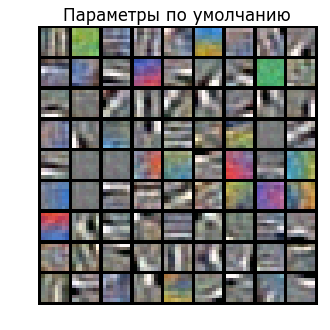

In [157]:
plt.figure(figsize=(5, 5))
t = res['x'][:visible_size * hidden_size[0]].reshape(visible_size, hidden_size[0]).T
plt.imshow(convert_to_table(normalize_data(t) - 0.1) / 0.8, interpolation='nearest')
plt.axis('off')
plt.title('Параметры по умолчанию')
plt.show()

### Визуализация различия между исходными и восстановленными изображениями

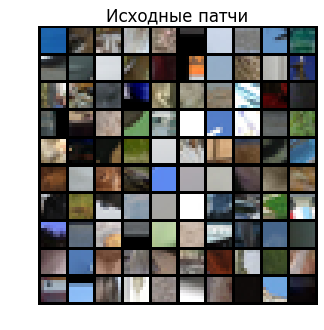

In [160]:
plt.figure(figsize=(5, 5))
t = samples[:100]
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Исходные патчи')
plt.show()

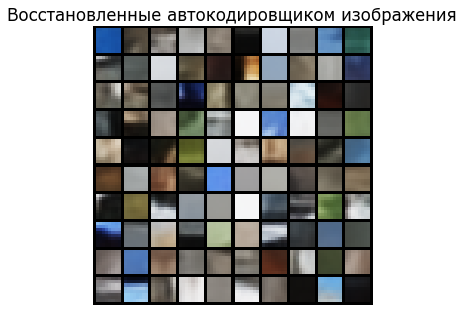

In [163]:
plt.figure(figsize=(5, 5))
t = autoencoder_transform(best_param_2, visible_size, hidden_size, 2, samples[:100])
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Восстановленные автокодировщиком изображения')
plt.show()

Как видно, автокодировщик довольно неплохо выделяет ключевые элементы патчей (перепады цвета, светлые и темные пятна). Результат похож на размытые исходные изображения

### Исследование зависимости качества обучения автокодировщика от гиперпараметров

В качестве гиперпараметов по умолчанию использовались $\lambda = 0.0001, \rho = 0.05, \beta = 1$

In [148]:
opt = initialize(hidden_size, visible_size)

In [7]:
data_train = sample_patches_raw(data, 10000, 8)
data_test = sample_patches_raw(data, 10000, 8)

Ошибка для эталонных параметров:

In [149]:
%%time
result = minimize(autoencoder_loss, opt, 
               (visible_size, hidden_size, lambda_, sparsity_param, beta, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
default = result['x']
print(((autoencoder_transform(default, visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())

0.00398421881065
Wall time: 29min 33s


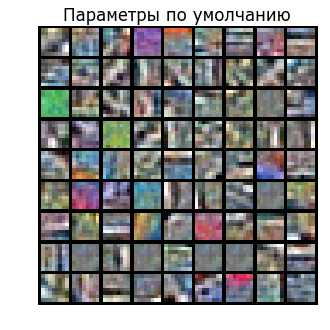

In [150]:
plt.figure(figsize=(5, 5))
t = default[:visible_size * hidden_size[0]].reshape(visible_size, hidden_size[0]).T
plt.imshow(convert_to_table(normalize_data(t) - 0.1) / 0.8, interpolation='nearest')
plt.axis('off')
plt.title('Параметры по умолчанию')
plt.show()

In [151]:
param_hyper = [opt.copy()] * 6

In [152]:
%%time
result = minimize(autoencoder_loss, param_hyper[0], 
               (visible_size, hidden_size, 1e-3, sparsity_param, beta, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[0] = result['x']
print('lambda = 1e-3:', 
      ((autoencoder_transform(param_hyper[0], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())
result = minimize(autoencoder_loss, param_hyper[1], 
               (visible_size, hidden_size, 1e-5, sparsity_param, beta, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[1] = result['x']
print('lambda = 1e-5:', 
      ((autoencoder_transform(param_hyper[1], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())

lambda = 1e-3: 0.00954916371584
lambda = 1e-5: 0.00636165567592
Wall time: 54min 59s


In [153]:
%%time
result = minimize(autoencoder_loss, param_hyper[2], 
               (visible_size, hidden_size, lambda_, 0.01, beta, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[2] = result['x']
print('rho = 0.01:', 
      ((autoencoder_transform(param_hyper[2], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())
result = minimize(autoencoder_loss, param_hyper[3], 
               (visible_size, hidden_size, lambda_, 0.1, beta, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[3] = result['x']
print('rho = 0.1:', 
      ((autoencoder_transform(param_hyper[3], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())

rho = 0.01: 0.00767157547278
rho = 0.1: 0.00240147338016
Wall time: 1h 32s


In [154]:
%%time
result = minimize(autoencoder_loss, param_hyper[4], 
               (visible_size, hidden_size, lambda_, sparsity_param, 0.1, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[4] = result['x']
print('beta = 0.1:', 
      ((autoencoder_transform(param_hyper[4], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())
result = minimize(autoencoder_loss, param_hyper[5], 
               (visible_size, hidden_size, lambda_, sparsity_param, 5, data_train), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
param_hyper[5] = result['x']
print('beta = 5:', 
      ((autoencoder_transform(param_hyper[5], visible_size, hidden_size, 2, data_test) - data_test) ** 2).mean())

beta = 0.1: 0.00280407455914
beta = 5: 0.00428130131247
Wall time: 59min 19s


Фильтры, полученные при изменении гиперпараметров

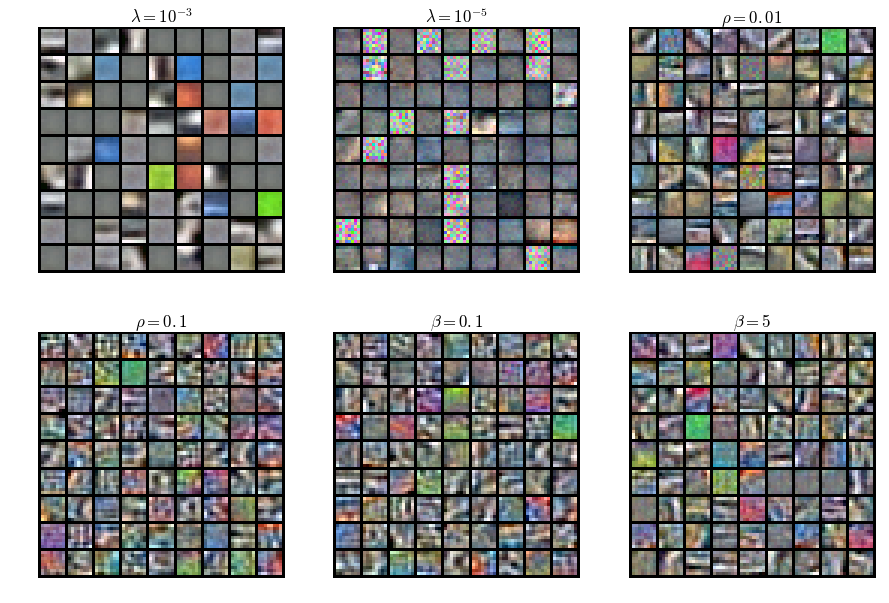

In [155]:
ttl = [r'$\lambda = 10^{-3}$', r'$\lambda = 10^{-5}$', r'$\rho = 0.01$', r'$\rho = 0.1$', r'$\beta = 0.1$', r'$\beta = 5$']
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    t = param_hyper[i][:visible_size * hidden_size[0]].reshape(visible_size, hidden_size[0]).T
    plt.imshow(convert_to_table(normalize_data(t) - 0.1) / 0.8, interpolation='nearest')
    plt.axis('off')
    plt.title(ttl[i])
plt.show()

Как видно, качество восстановления изображений можно улучшить, увеличив $\rho$ или уменьшив $\beta$. Но при этом мы ослабляем ограничения на разреженность скрытых слоев, поэтому фильтры получаюся слишком зашумленными.

### Использование автокодировщика для классификации изображений

In [8]:
f = open('train.pk', 'rb')
pic = pickle.load(f)
train_x = pic['X'] / 255
train_y = pic['y']
del pic

In [9]:
f = open('test.pk', 'rb')
pic = pickle.load(f)
test_x = pic['X'] / 255
test_y = pic['y']
del pic

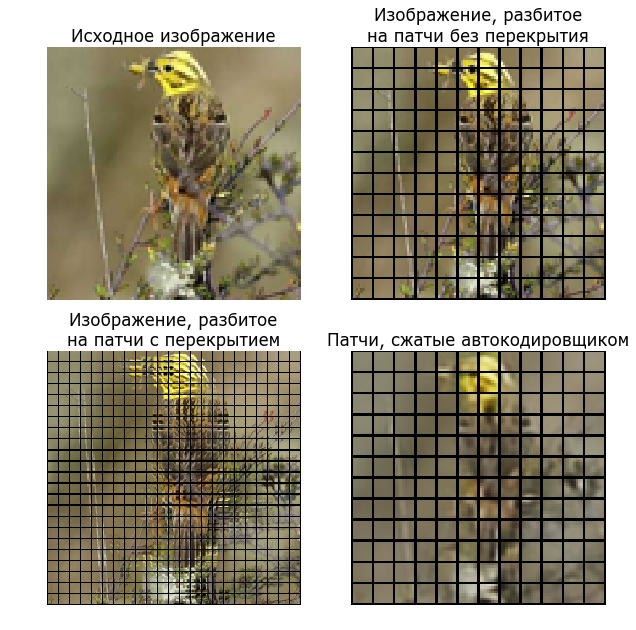

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_x[0].reshape(96, 96, 3), interpolation='nearest')
plt.axis('off')
plt.title('Исходное изображение')
plt.subplot(2, 2, 2)
t = split_images_for_patches(train_x[:1], 8, 8)[0]
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Изображение, разбитое\nна патчи без перекрытия')
plt.subplot(2, 2, 3)
t = split_images_for_patches(train_x[:1], 4, 8)[0]
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Изображение, разбитое\nна патчи с перекрытием')
plt.subplot(2, 2, 4)
t = autoencoder_transform(best_param_2, visible_size, hidden_size, 2, split_images_for_patches(train_x[:1], 8, 8)[0])
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Патчи, сжатые автокодировщиком')
plt.show()

In [10]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Алгоритмы, обученные на пикселах

In [13]:
svm = LinearSVC().fit(train_x, train_y.ravel())
rf = RandomForestClassifier(n_estimators=100, max_depth=100).fit(train_x, train_y.ravel())

In [15]:
acc_svm_px = 0
acc_rf_px = 0
k = 20
s = test_x.shape[0] // k
for i in range(k):
    acc_svm_px += accuracy_score(test_y[s * i : s * (i + 1)].ravel(), svm.predict(test_x[s * i : s * (i + 1)]))
    acc_rf_px += accuracy_score(test_y[s * i : s * (i + 1)].ravel(), rf.predict(test_x[s * i : s * (i + 1)]))
acc_svm_px /= k
acc_rf_px /= k
print('SVM, pixels, acc=%g' % (acc_svm_px))
print('Random Forest, pixels, acc=%g' % (acc_rf_px))

SVM, pixels, acc=0.27215
Random Forest, pixels, acc=0.37875


Алгоритмы, обученные при помощи автокодировщика

In [10]:
%%time
acc_svm = []
acc_rf = []
steps = [4, 6, 8, 12, 16, 24, 32]
for step in steps:
    tr_patches = split_images_for_patches(train_x, step, 8)
    tr_act = autoencoder_transform(best_param_2, visible_size, hidden_size, 1, np.concatenate(tr_patches, axis=0))
    tr_act = tr_act.reshape(tr_patches.shape[0], tr_patches.shape[1] * tr_act.shape[1])
    svm = LinearSVC().fit(tr_act, train_y.ravel())
    rf = RandomForestClassifier(n_estimators=100, max_depth=100).fit(tr_act, train_y.ravel())
    del tr_act, tr_patches
    acc_svm.append(0)
    acc_rf.append(0)
    k = 50
    s = test_x.shape[0] // k
    for i in range(k):
        tt_patches = split_images_for_patches(test_x[s * i : s * (i + 1)], step, 8)
        tt_act = autoencoder_transform(best_param_2, visible_size, hidden_size, 1, np.concatenate(tt_patches, axis=0))
        tt_act = tt_act.reshape(tt_patches.shape[0], tt_patches.shape[1] * tt_act.shape[1])
        acc_svm[-1] += accuracy_score(test_y[s * i : s * (i + 1)], svm.predict(tt_act))
        acc_rf[-1] += accuracy_score(test_y[s * i : s * (i + 1)], rf.predict(tt_act))
    acc_svm[-1] /= k
    acc_rf[-1] /= k
    print('SVM, step=%d, acc=%g' % (step, acc_svm[-1]))
    print('Random Forest, step=%d, acc=%g' % (step, acc_rf[-1]))
    del tt_act, tt_patches   

SVM, step=4, acc=0.423
Random Forest, step=4, acc=0.395
SVM, step=6, acc=0.415125
Random Forest, step=6, acc=0.389375
SVM, step=8, acc=0.421625
Random Forest, step=8, acc=0.39275
SVM, step=12, acc=0.389875
Random Forest, step=12, acc=0.382
SVM, step=16, acc=0.35625
Random Forest, step=16, acc=0.37925
SVM, step=24, acc=0.3205
Random Forest, step=24, acc=0.35425
SVM, step=32, acc=0.29775
Random Forest, step=32, acc=0.335875
Wall time: 39min 2s


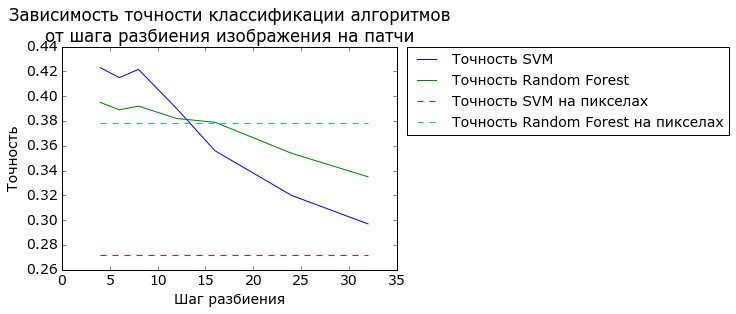

In [25]:
plt.plot(steps, acc_svm, label='Точность SVM')
plt.plot(steps, acc_rf, label='Точность Random Forest')
plt.plot(steps, [acc_svm_px] * len(steps), '--', label='Точность SVM на пикселах')
plt.plot(steps, [acc_rf_px] * len(steps), '--', label='Точность Random Forest на пикселах')
plt.xlabel('Шаг разбиения')
plt.ylabel('Точность')
plt.title('Зависимость точности классификации алгоритмов\nот шага разбиения изображения на патчи')
plt.legend(bbox_to_anchor=[1.01, 1.03], loc='upper left')
plt.show()

Судя по полученным результатам, наилучшей точности классификации удается достичь при максимально частом шаге разбиения на патчи. При этом результат для SVM'а улучшился почти в полтора раза, в то время как для Random Forest'а получили незначительное увеличение точности.

### Сравнение с автокодировщиком с тремя скрытыми слоями

In [12]:
visible_size2 = 8 * 8 * 3
hidden_size2 = np.array([100, 60, 100], dtype='int32')
lambda_, sparsity_param, beta = 1e-4, 5e-2, 1

In [9]:
theta = initialize(hidden_size2, visible_size2)

In [10]:
%%time
res = minimize(autoencoder_loss, theta, 
               (visible_size2, hidden_size2, lambda_, sparsity_param, beta, samples), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})

Wall time: 2h 17min 1s


Среднеквадратичное отклонение восстановленных изображений от исходных

In [11]:
param_3l = res['x']

In [25]:
print(((autoencoder_transform(param_3l, visible_size2, hidden_size2, 4, data_test) - data_test) ** 2).mean())

0.00678763349484


Напомню, для одного скрытого слоя среднеквадратичная ошибка составляла 0.004

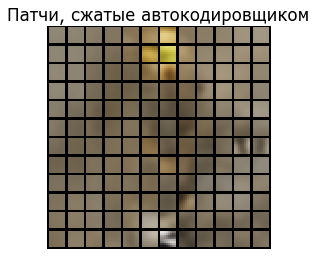

In [26]:
plt.Figure((5, 5))
t = autoencoder_transform(res['x'], visible_size2, hidden_size2, 4, split_images_for_patches(train_x[:1], 8, 8)[0])
plt.imshow(convert_to_table(t), interpolation='nearest')
plt.axis('off')
plt.title('Патчи, сжатые автокодировщиком')
plt.show()

Досточно сложно в полученных патчах увидеть ту же птичку, что и в предыдущих примерах. Возможно, сеть с такой сложной структурой нужно обучать еще дольше

In [32]:
acc_svm_3l = 0
acc_rf_3l = 0
tr_patches = split_images_for_patches(train_x, 4, 8)
tr_act = autoencoder_transform(param_3l, visible_size2, hidden_size2, 2, np.concatenate(tr_patches, axis=0))
tr_act = tr_act.reshape(tr_patches.shape[0], tr_patches.shape[1] * tr_act.shape[1])
svm = LinearSVC().fit(tr_act, train_y.ravel())
rf = RandomForestClassifier(n_estimators=100, max_depth=100).fit(tr_act, train_y.ravel())
del tr_act, tr_patches
k = 100
s = test_x.shape[0] // k
for i in range(k):
    tt_patches = split_images_for_patches(test_x[s * i : s * (i + 1)], 4, 8)
    tt_act = autoencoder_transform(param_3l, visible_size2, hidden_size2, 2, np.concatenate(tt_patches, axis=0))
    tt_act = tt_act.reshape(tt_patches.shape[0], tt_patches.shape[1] * tt_act.shape[1])
    acc_svm_3l += accuracy_score(test_y[s * i : s * (i + 1)], svm.predict(tt_act))
    acc_rf_3l += accuracy_score(test_y[s * i : s * (i + 1)], rf.predict(tt_act))
    del tt_act, tt_patches   
acc_svm_3l /= k
acc_rf_3l /= k
print('SVM, 3 hidden layers, step=4, acc=%g' % (acc_svm_3l))
print('Random Forest, 3 hidden layers, step=4, acc=%g' % (acc_rf_3l))

SVM, 3 hidden layers, step=4, acc=0.3755
Random Forest, 3 hidden layers, step=4, acc=0.34925


Точность классификации данных, полученных из автокодировщика с тремя скрытыми слоями, значительно уступает аналогичным результатам для кодировщика с одним скрытым слоем.

### Исследование зависимости точности классификации от числа патчей в обучающей выборке

In [79]:
patches_arr = [100, 500, 1000, 5000, 10000]

In [34]:
param = [theta.copy() for i in patches_arr]

In [35]:
visible_size = 8 * 8 * 3
hidden_size = np.array([81], dtype='int32')
lambda_, sparsity_param, beta = 1e-4, 5e-2, 1
theta = initialize(hidden_size, visible_size)

In [78]:
for i, n_patches in enumerate(patches_arr):
    samples = sample_patches_raw(data, n_patches, 8)
    result = minimize(autoencoder_loss, param[i], 
               (visible_size, hidden_size, lambda_, sparsity_param, beta, samples), 
               method='L-BFGS-B', jac=True, options={'disp': True, 'maxiter': 5000})
    param[i] = result['x']

In [45]:
pickle.dump(param, open('param.txt', 'wb'))

In [76]:
acc_svm2 = []
acc_rf2 = []
svm = []
rf = []
tr_patches = split_images_for_patches(train_x, 4, 8)
for i in range(len(patches_arr)):
    tr_act = autoencoder_transform(param[i], visible_size, hidden_size, 1, np.concatenate(tr_patches, axis=0))
    tr_act = tr_act.reshape(tr_patches.shape[0], tr_patches.shape[1] * tr_act.shape[1])
    svm.append(LinearSVC().fit(tr_act, train_y.ravel()))
    rf.append(RandomForestClassifier(n_estimators=100, max_depth=100).fit(tr_act, train_y.ravel()))
    acc_svm2.append(0)
    acc_rf2.append(0)
del tr_act, tr_patches
k = 100
s = test_x.shape[0] // k
for i in range(k):
    tt_patches = split_images_for_patches(test_x[s * i : s * (i + 1)], 4, 8)
    for j in range(len(patches_arr)):
        tt_act = autoencoder_transform(param[j], visible_size, hidden_size, 1, np.concatenate(tt_patches, axis=0))
        tt_act = tt_act.reshape(tt_patches.shape[0], tt_patches.shape[1] * tt_act.shape[1])
        acc_svm2[j] += accuracy_score(test_y[s * i : s * (i + 1)], svm[j].predict(tt_act))
        acc_rf2[j] += accuracy_score(test_y[s * i : s * (i + 1)], rf[j].predict(tt_act))
    del tt_act, tt_patches   
for j in range(len(patches_arr)):
    acc_svm2[j] /= k
    acc_rf2[j] /= k
    print('SVM, n_patches=%d, acc=%g' % (patches_arr[j], acc_svm2[j]))
    print('Random Forest, n_patches=%d, acc=%g' % (patches_arr[j], acc_rf2[j]))

SVM, n_patches=100, acc=0.405
Random Forest, n_patches=100, acc=0.37375
SVM, n_patches=500, acc=0.40425
Random Forest, n_patches=500, acc=0.375
SVM, n_patches=1000, acc=0.4075
Random Forest, n_patches=1000, acc=0.37475
SVM, n_patches=5000, acc=0.41
Random Forest, n_patches=5000, acc=0.36925
SVM, n_patches=10000, acc=0.41275
Random Forest, n_patches=10000, acc=0.37975


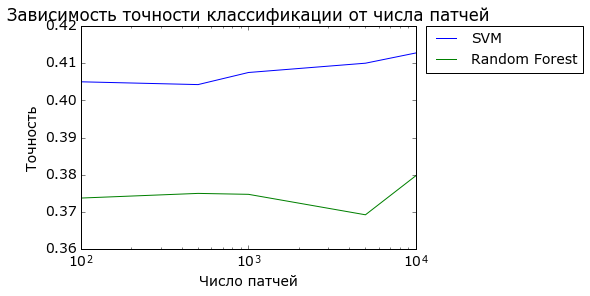

In [77]:
plt.semilogx(patches_arr, acc_svm2, label='SVM')
plt.semilogx(patches_arr, acc_rf2, label='Random Forest')
plt.xlabel('Число патчей')
plt.ylabel('Точность')
plt.title('Зависимость точности классификации от числа патчей')
plt.legend(bbox_to_anchor=[1.01, 1.03], loc='upper left')
plt.show()

Судя по графику, точность слабо зависит от числа патчей в обучающей выборке, однако незначительно увеличивается с увеличением их числа.

### Выводы

В процессе работы над заданием был реализован разреженный автокодировщик и несколько вспомогательных модулей для работы с ним.

Также был поставлен ряд экспериментов по поиску оптимальных параметров обучения. Было обнаружено, что при требовании разреженности скрытых слоев автокодировщика оптимальным представлением изображений являются градиенты и границы объектов.

Согласно поставленным экспериментам, найденные гиперпараметры ($\lambda = 10^{-4}, \rho = 0.05, \beta = 1$) дают наилучший результат, с одной стороны, хорошо выделяя фильтры, а с другой, сохраняя достаточную точность восстановления изображений.

Для исследованных алгоритмов (SVM и Random Forest) при разбиении на патчи размера 8 наилучшего качества удалось достичь при разбиении с шагом 4, то есть максимально часто. При этом удалось получить заметный прирост точности по сравнению с обучением на интенсивностях пикселей. Лучшая точность - 0.423, на SVM и патчах с шагом 4.

Было обнаружено, что добавление еще двух скрытых слоев только ухудшает как точность классификации, так и точность восстановления изображений.

Также согласно экспериментам, увеличение объема выборки при обучении автокодировщика дает незначительное увеличение качества последующей классификации.